In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import colorsys
import os

# ===== Helper functions =====

def rgb_to_hsv(rgb):
    return colorsys.rgb_to_hsv(rgb[0] / 255.0, rgb[1] / 255.0, rgb[2] / 255.0)

def classify_color(hsv_color):
    h, s, v = hsv_color
    warm_cool = "Warm" if 0 <= h < 0.5 else "Cool"
    vibrant_muted = "Vibrant" if s > 0.5 else "Muted"
    light_dark = "Light" if v > 0.5 else "Dark"
    return warm_cool, vibrant_muted, light_dark

def extract_colors_from_palette(image_path, max_colors=10):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((-1, 3))
    colors, counts = np.unique(img, axis=0, return_counts=True)
    sorted_indices = np.argsort(-counts)
    top_colors = colors[sorted_indices][:max_colors]
    return [tuple(color) for color in top_colors]

def process_folder_of_palettes(folder_path):
    palettes = {}
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            palettes[filename] = extract_colors_from_palette(img_path)
    return palettes

def process_color_palettes(palettes):
    classified_data = []
    for image, palette in palettes.items():
        for color in palette:
            hsv_color = rgb_to_hsv(color)
            warm_cool, vibrant_muted, light_dark = classify_color(hsv_color)
            classified_data.append({
                'image': image,
                'color': color,
                'warm_cool': warm_cool,
                'vibrant_muted': vibrant_muted,
                'light_dark': light_dark
            })
    return pd.DataFrame(classified_data)

def generate_trend_report(color_data):
    trend_report = color_data.groupby(['warm_cool', 'vibrant_muted', 'light_dark']).size().reset_index(name='count')
    total_colors = trend_report['count'].sum()
    trend_report['percentage'] = (trend_report['count'] / total_colors) * 100
    return trend_report

# ===== Color family palette for aesthetic matching =====
color_family_colors = {
    'Warm Vibrant Light': '#FFA07A',
    'Warm Vibrant Dark': '#CD5C5C',
    'Warm Muted Light': '#FFDAB9',
    'Warm Muted Dark': '#8B4513',
    'Cool Vibrant Light': '#87CEFA',
    'Cool Vibrant Dark': '#4682B4',
    'Cool Muted Light': '#B0C4DE',
    'Cool Muted Dark': '#2F4F4F'
}

# ===== Plotting Functions =====

def plot_color_trends(trend_report, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    # Bar chart helper
    def bar_chart(data, column, title, filename, color_map):
        plt.figure(figsize=(6, 4))
        bars = data.groupby(column)['percentage'].sum()
        bars.plot(kind='bar', color=[color_map.get(x, 'gray') for x in bars.index], alpha=0.8)
        plt.title(title)
        plt.ylabel('Percentage')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, filename))
        plt.close()

    warm_cool_colors = {"Warm": "#FFA07A", "Cool": "#87CEFA"}
    vibrant_muted_colors = {"Vibrant": "#FF6347", "Muted": "#A9A9A9"}
    light_dark_colors = {"Light": "#FAFAD2", "Dark": "#2F4F4F"}

    bar_chart(trend_report, "warm_cool", "Trends in Warm vs Cool Colors for Schiaparelli, Chanel, and Jac", "warm_cool_trend.png", warm_cool_colors)
    bar_chart(trend_report, "vibrant_muted", "Trends in Vibrant vs Muted Colors for Schiaparelli, Chanel, and Jac", "vibrant_muted_trend.png", vibrant_muted_colors)
    bar_chart(trend_report, "light_dark", "Trends in Light vs Dark Colors for Schiaparelli, Chanel, and Jac", "light_dark_trend.png", light_dark_colors)

def plot_color_family_pie(color_data, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    color_data['color_family'] = color_data['warm_cool'] + " " + color_data['vibrant_muted'] + " " + color_data['light_dark']
    family_counts = color_data['color_family'].value_counts()
    labels = family_counts.index
    sizes = family_counts.values
    colors = [color_family_colors.get(label, 'gray') for label in labels]

    plt.figure(figsize=(12, 12))  # Increase figure size for better readability
    wedges, texts, autotexts = plt.pie(
        sizes, 
        labels=labels, 
        colors=colors, 
        autopct='%1.1f%%', 
        startangle=140,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1},  # Add borders to wedges for better separation
        pctdistance=0.75,  # Adjust distance of percentages from the center
        labeldistance=1.05  # Adjust label distance
    )
    
    # Adjusting text properties for better readability
    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')
    for autotext in autotexts:
        autotext.set_fontsize(10)
        autotext.set_fontweight('bold')

    plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    plt.title('Color Family Distribution for Schiaparelli, Chanel, and Jacquemus', fontsize=16, fontweight='bold')
    
    # Add a legend outside the pie chart to avoid overcrowding
    plt.legend(
        wedges, labels, title="Color Families", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1),
        fontsize=12, frameon=False
    )
    
    plt.tight_layout()  # Ensure everything fits well
    plt.savefig(os.path.join(save_dir, "color_family_pie_chart_updated.png"))
    plt.close()




def create_color_swatch_legend(colors_dict, save_path):
    labels = list(colors_dict.keys())
    hex_colors = [colors_dict[label] for label in labels]

    fig, ax = plt.subplots(figsize=(10, 5))
    for i, (label, hex_color) in enumerate(zip(labels, hex_colors)):
        ax.barh(i, 1, color=hex_color)
        ax.text(1.05, i, label, va='center', ha='left', fontsize=12)
    ax.set_xlim(0, 1.5)
    ax.set_ylim(-0.5, len(labels) - 0.5)
    ax.axis('off')
    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    plt.close()


In [6]:
# ====== MAIN WORKFLOW ======

# Set paths
palette_folder = "/Users/user/Desktop/Project Submission/Implementation/Source Code/Source Code/project 2/public/images/ColorAnalysisResults"   # Folder where palettes/images are
save_dir = "/Users/user/Desktop/Project Submission/Implementation/Source Code/Source Code/project 2/public/images/Color Trends"                  # Folder to save plots and reports

# Making sure the save directory exists
os.makedirs(save_dir, exist_ok=True)

# 1. Read palettes
palettes = process_folder_of_palettes(palette_folder)

# 2. Classify colors
color_data = process_color_palettes(palettes)

# 3. Generate trend report
trend_report = generate_trend_report(color_data)
print(trend_report)

# 4. Save trend plots
plot_color_trends(trend_report, save_dir)

# 5. Save color family pie chart
plot_color_family_pie(color_data, save_dir)

# 6. Save full classified data
color_data.to_csv(os.path.join(save_dir, "classified_colors.csv"), index=False)

# 7. Save color family swatch legend
create_color_swatch_legend(color_family_colors, os.path.join(save_dir, "color_family_legend.png"))


print("All color analysis results saved successfully!")


  warm_cool vibrant_muted light_dark  count  percentage
0      Cool         Muted       Dark     34        2.72
1      Cool         Muted      Light     46        3.68
2      Cool       Vibrant       Dark      5        0.40
3      Cool       Vibrant      Light     12        0.96
4      Warm         Muted       Dark    289       23.12
5      Warm         Muted      Light    683       54.64
6      Warm       Vibrant       Dark    129       10.32
7      Warm       Vibrant      Light     52        4.16
All color analysis results saved successfully!


In [20]:
# ====== FUNCTION: Map colors to closest Pantone ======

from scipy.spatial import distance


pantone_colors = {
    "Pantone Red 032 C": (239, 51, 64),
    "Pantone 123 C": (255, 199, 44),
    "Pantone 299 C": (0, 163, 224),
    "Pantone 354 C": (0, 179, 79),
    "Pantone 2685 C": (63, 0, 125),
    "Pantone Cool Gray 7 C": (151, 153, 155),
    "Pantone Black C": (45, 41, 38),
    "Pantone White": (255, 255, 255),
    "Pantone 7406 C": (252, 209, 22),
    "Pantone 021 C": (255, 79, 0),
    "Pantone 7739 C": (0, 103, 62),
    "Pantone 2758 C": (0, 32, 91),
    "Pantone 2395 C": (231, 0, 140),
    "Pantone 7465 C": (0, 191, 165),
    "Pantone 165 C": (255, 130, 0),
    "Pantone 134": (255, 227, 140),
    "Pantone 1355": (255, 204, 112),
    "Pantone 1345": (255, 219, 135),
    "Pantone 148": (255, 214, 161),
    "Pantone 1485": (255, 186, 117),
    "Pantone 1545": (71, 34, 0),
    "Pantone 155": (255, 224, 184),
    "Pantone 187": (204, 0, 43),
    "Pantone 2562": (207, 166, 255),
    "Pantone 257": (219, 168, 255),
    "Pantone 264": (189, 184, 255),
    "Pantone 5255": (39, 0, 133),
    "Pantone Cool Gray 2 C": (230, 230, 230),
    "Pantone Cool Gray 7 C (Alt)": (161, 161, 161),
    "Pantone 729": (209, 144, 82),
    "Pantone 7420": (204, 41, 118),
    "Pantone 7528": (230, 223, 207),
    "Pantone 7530": (173, 160, 137),
    "Pantone 7527": (237, 232, 223),
    "Warm Grey 7": (158, 145, 136)
    
}


# Define a mapping of Pantone colors to their respective color families
pantone_color_families = {
    "Pantone Red 032 C": "Red",
    "Pantone 123 C": "Yellow",
    "Pantone 299 C": "Blue",
    "Pantone 354 C": "Green",
    "Pantone 2685 C": "Purple",
    "Pantone Cool Gray 7 C": "Gray",
    "Pantone Black C": "Black",
    "Pantone White": "White",
    "Pantone 7406 C": "Yellow",
    "Pantone 021 C": "Orange",
    "Pantone 7739 C": "Green",
    "Pantone 2758 C": "Blue",
    "Pantone 2395 C": "Pink",
    "Pantone 7465 C": "Green",
    "Pantone 165 C": "Orange",
    "Pantone 134": "Yellow",
    "Pantone 1355": "Yellow",
    "Pantone 1345": "Yellow",
    "Pantone 148": "Yellow",
    "Pantone 1485": "Yellow",
    "Pantone 1545": "Brown",
    "Pantone 155": "Yellow",
    "Pantone 187": "Red",
    "Pantone 2562": "Purple",
    "Pantone 257": "Purple",
    "Pantone 264": "Purple",
    "Pantone 5255": "Purple",
    "Pantone Cool Gray 2 C": "Gray",
    "Pantone Cool Gray 7 C (Alt)": "Gray",
    "Pantone 729": "Brown",
    "Pantone 7420": "Pink",
    "Pantone 7528": "Neutral",
    "Pantone 7530": "Neutral",
    "Pantone 7527": "Neutral",
    "Warm Grey 7": "Gray" 
}


# Function to find closest Pantone
def find_closest_pantone(color_rgb):
    min_distance = float('inf')
    closest_pantone = None
    closest_rgb = None
    
    for pantone_name, pantone_rgb in pantone_colors.items():
        dist = distance.euclidean(color_rgb, pantone_rgb)
        if dist < min_distance:
            min_distance = dist
            closest_pantone = pantone_name
            closest_rgb = pantone_rgb
    
    return closest_pantone, closest_rgb

# Main function to map palettes
def map_colors_to_pantone(palettes):
    """Map extracted palettes to their closest Pantone colors and their color families."""
    results = []
    
    for image, palette in palettes.items():
        for color in palette:
            # Find the closest Pantone color and its RGB
            pantone_name, pantone_rgb = find_closest_pantone(color)
            
            # Look up the Pantone color's family
            color_family = pantone_color_families.get(pantone_name, "Unknown")
            
            results.append({
                'image': image,
                'original_color': color,
                'closest_pantone': pantone_name,
                'pantone_rgb': pantone_rgb,
                'color_family': color_family  # Adding the color family
            })
    
    return pd.DataFrame(results)




In [16]:
# ====== PANTONE MAPPING WORKFLOW ======

# Load palettes again if needed (or reusing it)
# palettes = process_folder_of_palettes(palette_folder) 

# Map palettes to Pantone
pantone_matches = map_colors_to_pantone(palettes)

# Save directory
save_dir = "/Users/user/Desktop/Project Submission/Implementation/Source Code/Source Code/project 2/public/images/Color Trends" 

# Save Pantone results, now including the 'color_family' column
pantone_matches.to_csv(os.path.join(save_dir, "pantone_matches.csv"), index=False)

print("Pantone mapping saved successfully!")


Pantone mapping saved successfully!


In [21]:
import matplotlib.pyplot as plt

def show_pantone_matches(pantone_df, num_samples=10):
    """
    Display original colors and their closest Pantone matches side-by-side,
    including the Pantone color family.
    
    Args:
        pantone_df (DataFrame): The dataframe containing 'original_color', 'pantone_rgb', and 'color_family'.
        num_samples (int): Number of samples to show.
    """
    # Sampling the data (shuffling first for variety)
    sample = pantone_df.sample(n=min(num_samples, len(pantone_df))).reset_index(drop=True)
    
    fig, axs = plt.subplots(len(sample), 2, figsize=(6, len(sample) * 1.5))
    
    for idx, row in sample.iterrows():
        # Original color
        axs[idx, 0].imshow([[ [c/255 for c in row['original_color']] ]])
        axs[idx, 0].axis('off')
        axs[idx, 0].set_title("Original Color", fontsize=8)
        
        # Pantone match
        axs[idx, 1].imshow([[ [c/255 for c in row['pantone_rgb']] ]])
        axs[idx, 1].axis('off')
        axs[idx, 1].set_title(f"{row['closest_pantone']} ({row['color_family']})", fontsize=8)
    
    plt.tight_layout()
    plt.show()


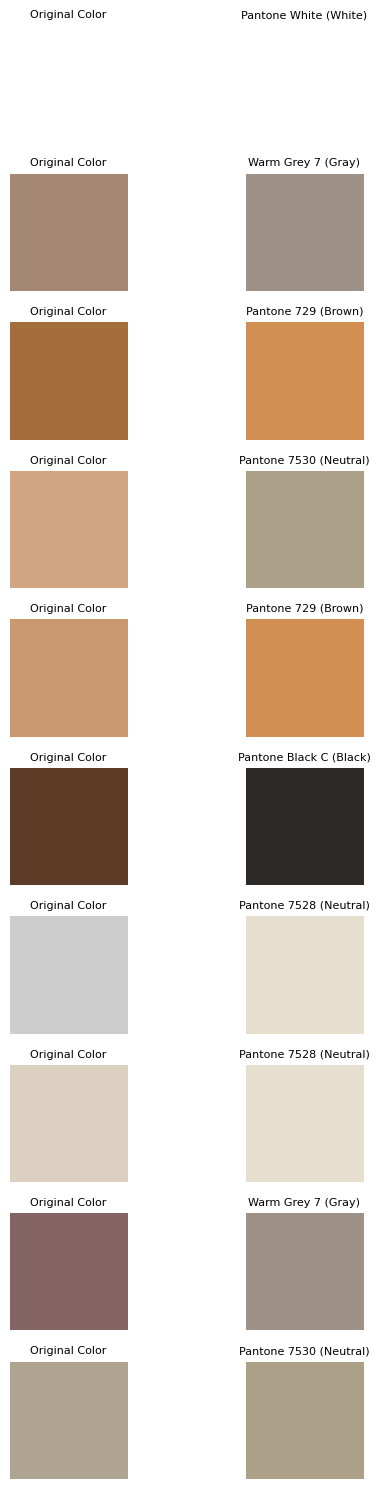

In [22]:
# Calling this after the 'pantone_matches' is ready!

show_pantone_matches(pantone_matches, num_samples=10)   


In [24]:
import matplotlib.pyplot as plt
import os

def save_pantone_matches_plot(pantone_df, save_path, num_samples=10, title="Color Match Preview", watermark="Runway Color Analysis 2025"):
    """
    Display and save a super fancy plot showing original and Pantone colors side-by-side, with names, hex codes, and confidence scores.
    
    Args:
        pantone_df (DataFrame): Must contain 'original_color', 'pantone_rgb', 'closest_pantone', 'confidence'.
        save_path (str): Path to save the PNG.
        num_samples (int): How many samples to plot.
        title (str): Title of the chart.
        watermark (str): Watermark text at the bottom.
    """
    sample = pantone_df.sample(n=min(num_samples, len(pantone_df))).reset_index(drop=True)

    fig, axs = plt.subplots(len(sample), 2, figsize=(10, len(sample) * 2))
    fig.suptitle(title, fontsize=18, weight='bold', color="#222222", y=1.02)

    for idx, row in sample.iterrows():
        orig_rgb = tuple([int(x) for x in row['original_color']])
        pantone_rgb = tuple([int(x) for x in row['pantone_rgb']])

        # ORIGINAL COLOR SQUARE
        axs[idx, 0].imshow([[[c/255 for c in orig_rgb]]])
        axs[idx, 0].axis('off')
        axs[idx, 0].set_title("Original Color", fontsize=10, pad=8)

        # Add HEX code below
        hex_orig = '#%02x%02x%02x' % orig_rgb
        axs[idx, 0].text(0.5, -0.2, hex_orig.upper(), fontsize=8, ha='center', transform=axs[idx, 0].transAxes)

        # PANTONE COLOR SQUARE
        axs[idx, 1].imshow([[[c/255 for c in pantone_rgb]]])
        axs[idx, 1].axis('off')

        pantone_name = row['closest_pantone']
        confidence = row.get('confidence', None)

        # Title = Pantone Name + Confidence %
        if confidence is not None:
            axs[idx, 1].set_title(f"{pantone_name}\n({confidence:.1f}%)", fontsize=10, pad=8)
        else:
            axs[idx, 1].set_title(f"{pantone_name}", fontsize=10, pad=8)

        # HEX code under Pantone
        hex_pantone = '#%02x%02x%02x' % pantone_rgb
        axs[idx, 1].text(0.5, -0.2, hex_pantone.upper(), fontsize=8, ha='center', transform=axs[idx, 1].transAxes)

        # Soft Gridlines
        for side in ['top', 'bottom', 'left', 'right']:
            axs[idx, 0].spines[side].set_color('lightgray')
            axs[idx, 1].spines[side].set_color('lightgray')
            axs[idx, 0].spines[side].set_linewidth(0.5)
            axs[idx, 1].spines[side].set_linewidth(0.5)

    plt.tight_layout()

    # Adding watermark
    fig.text(0.99, 0.01, watermark, ha='right', va='bottom', fontsize=8, color='gray', alpha=0.6)

    # Save it
    plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=False)
    plt.close()

    print(f"Pantone preview saved at: {save_path}")


In [25]:
#Saving the plot:
save_dir = "/Users/user/Desktop/Project Submission/Implementation/Source Code/Source Code/project 2/public/images/Color Trends"
save_path = os.path.join(save_dir, "pantone_preview.png")

save_pantone_matches_plot(pantone_matches, save_path, num_samples=20)


Pantone preview saved at: /Users/user/Desktop/Color Trends/pantone_preview.png


Color family counts: color_family
Pink         2
Purple       5
Red          8
Yellow      54
White      127
Brown      156
Gray       217
Neutral    327
Black      354
Name: count, dtype: int64
Plot saved to /Users/user/Desktop/Color Trends/color_family_distribution.png


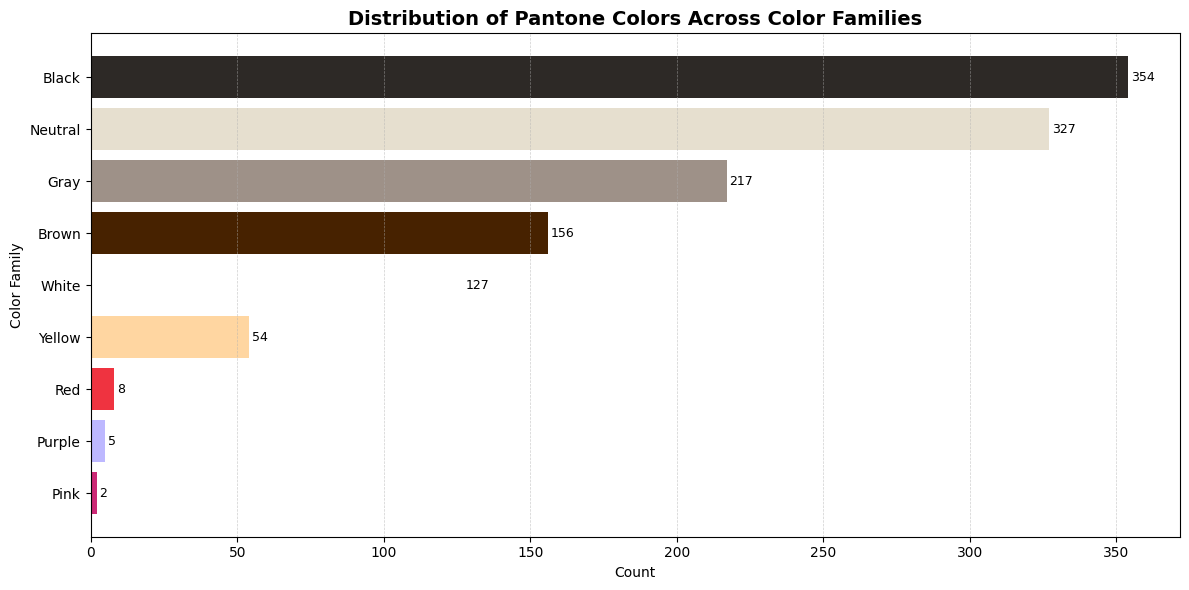

Color family counts saved to '/Users/user/Desktop/Color Trends/color_family_counts.csv'.
Unique color families: ['Black' 'White' 'Gray' 'Neutral' 'Brown' 'Yellow' 'Red' 'Pink' 'Purple']
Palette plot saved to /Users/user/Desktop/Color Trends/color_family_palettes.png


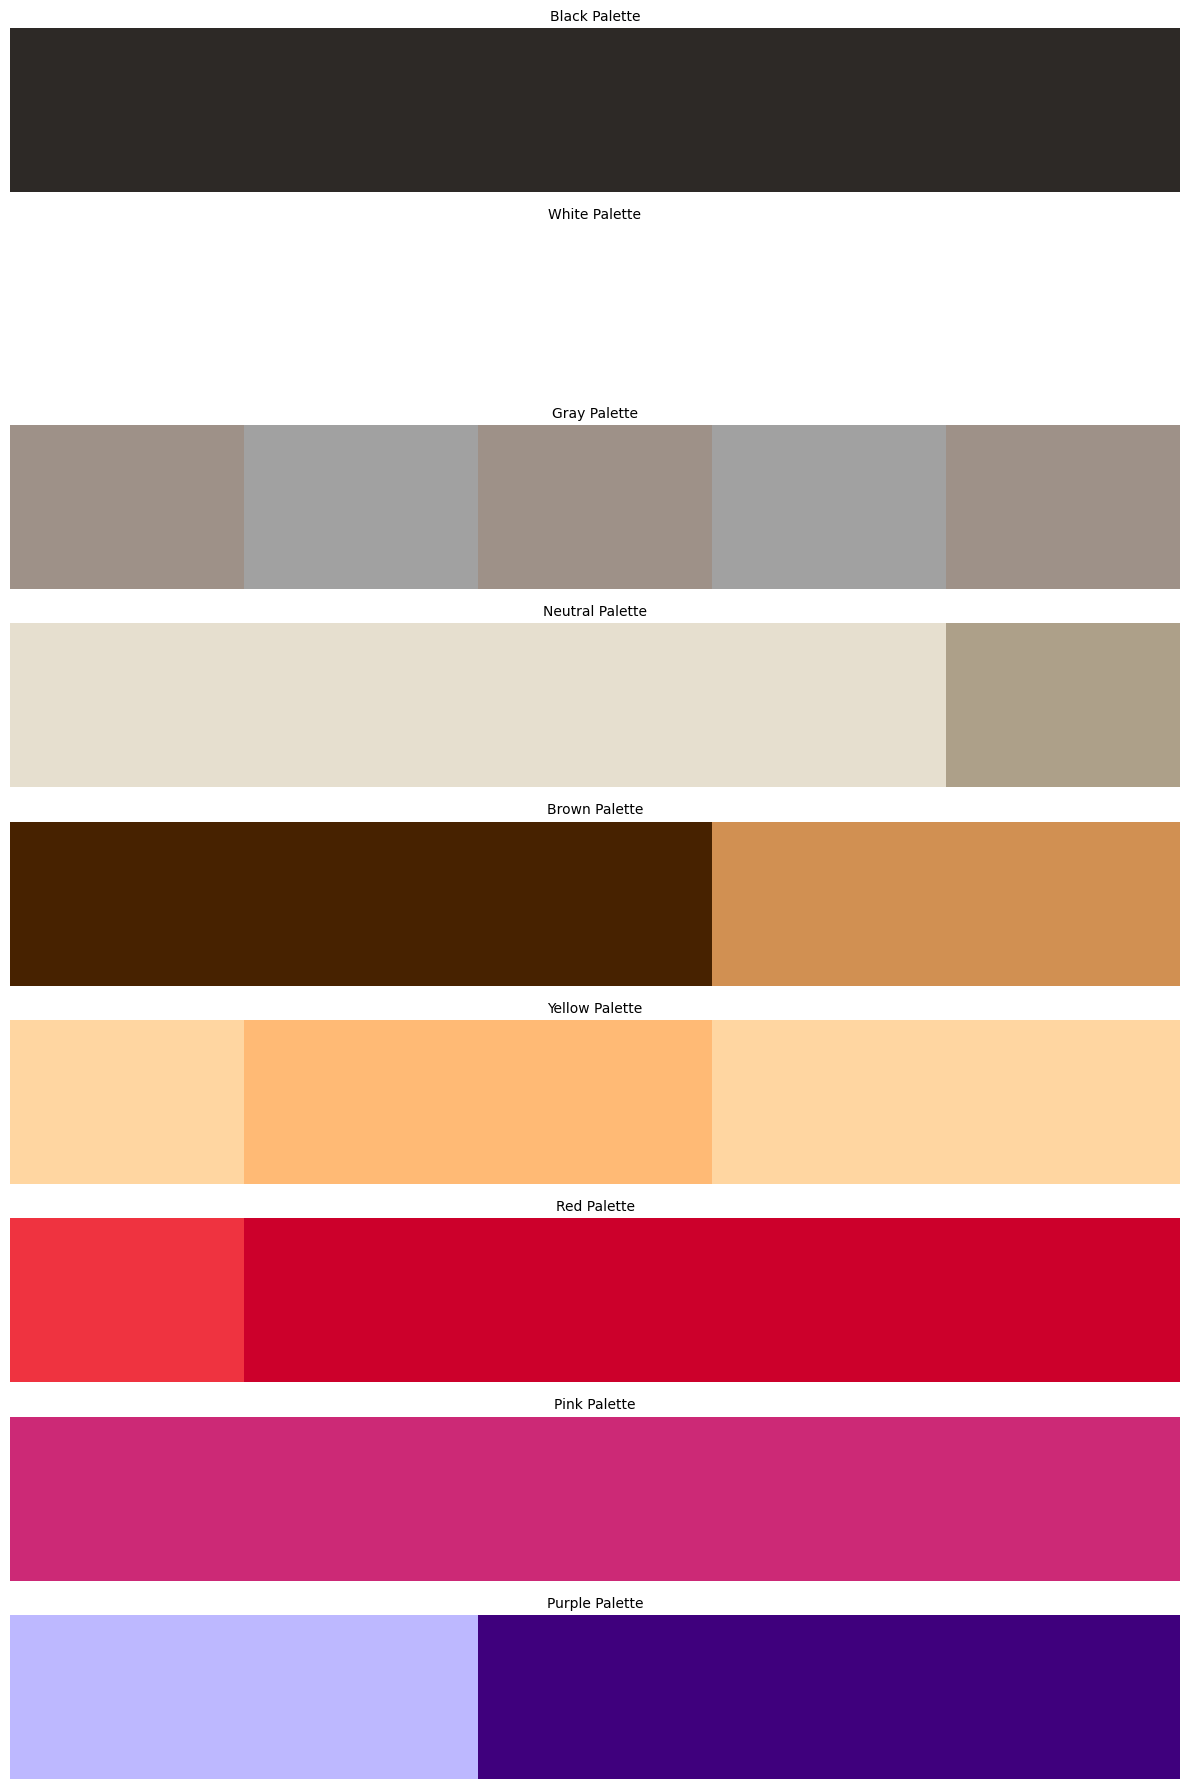

Color palettes saved to 'Color Trends/color_palettes_sample.csv'.


In [35]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Ensure the color_trends directory exists
os.makedirs("Color Trends", exist_ok=True)

# 1. Distribution Plot with Save
def plot_color_family_distribution(pantone_df, save_path="/Users/user/Desktop/Color Trends/color_family_distribution.png"):
    if pantone_df.empty:
        print("The DataFrame is empty. Please check the data.")
        return

    color_family_counts = pantone_df['color_family'].value_counts().sort_values(ascending=True)
    print(f"Color family counts: {color_family_counts}")

    plt.figure(figsize=(12, 6))

    for i, (color_family, count) in enumerate(color_family_counts.items()):
        pantone_rgb = pantone_df[pantone_df['color_family'] == color_family].iloc[0]['pantone_rgb']
        color = tuple(np.array(pantone_rgb) / 255)
        plt.barh(i, count, color=color)
        plt.text(count + 1, i, str(count), va='center', fontsize=9, color='black')

    plt.yticks(ticks=range(len(color_family_counts)), labels=color_family_counts.index)
    plt.title('Distribution of Pantone Colors Across Color Families', fontsize=14, weight='bold')
    plt.xlabel('Count')
    plt.ylabel('Color Family')
    plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    
    # Save plot and check if it is saved successfully
    plt.savefig(save_path, dpi=300)
    print(f"Plot saved to {save_path}")
    plt.show()

    # Save counts to CSV
    color_family_counts.to_csv("/Users/user/Desktop/Color Trends/color_family_counts.csv", header=['count'])
    print("Color family counts saved to '/Users/user/Desktop/Color Trends/color_family_counts.csv'.")

# 2. Palette Plot with Save
def plot_color_families_palette(pantone_df, num_colors_per_family=5, save_path="/Users/user/Desktop/Color Trends/color_family_palettes.png"):
    if pantone_df.empty:
        print("The DataFrame is empty. Please check the data.")
        return

    grouped = pantone_df.groupby('color_family').head(num_colors_per_family)
    unique_families = grouped['color_family'].unique()

    print(f"Unique color families: {unique_families}")

    plt.figure(figsize=(12, len(unique_families) * 2))

    for i, family in enumerate(unique_families):
        family_colors = grouped[grouped['color_family'] == family]['pantone_rgb'].values
        ax = plt.subplot(len(unique_families), 1, i + 1)
        ax.imshow([[(c[0] / 255, c[1] / 255, c[2] / 255) for c in family_colors]], aspect='auto')
        ax.axis('off')
        ax.set_title(f"{family} Palette", fontsize=10)

    plt.tight_layout()

    # Save plot and check if it is saved successfully
    plt.savefig(save_path, dpi=300)
    print(f"Palette plot saved to {save_path}")
    plt.show()

    # Save RGB values for palette
    palette_df = grouped[['color_family', 'closest_pantone', 'pantone_rgb']]
    palette_df.to_csv("/Users/user/Desktop/Color Trends/color_palettes_sample.csv", index=False)
    print("Color palettes saved to 'Color Trends/color_palettes_sample.csv'.")

# Run both
plot_color_family_distribution(pantone_matches)
plot_color_families_palette(pantone_matches)
